In [ ]:
import tensorflow
print(tensorflow.__version__)

2.15.0


# **Q1: Is the bus service accessible to everyone in Kingston (walk, bike, park & ride to a bus stop)?**

# **Download datasets in GeoJSON format**

Download the datasets for Q1 from our GitHub Repository
- Cycling Facilities: Existing on and off-road cycling infrastructure within the City of Kingston, Ontario, with the type of cycling facility that is currently in place identified.
- Neighbourhoods: Dataset of the boundaries of neighbourhoods within the City of Kingston, Ontario, as established from the 2011 census dissemination areas. Includes neighbourhood names.
- Parking Areas: Dataset representing the driven portion of a private or public parking area (not to be confused with a parking lot, which is a separate dataset).
- Transit Schedules, Routes & Stops (static): Kingston Transit General Transit Feed Specification (GTFS) for static schedule, route, and stop information.

In [5]:
!wget https://raw.githubusercontent.com/winfredtai/CISC451W24/main/A1/Datasets/geojson/cycling-facilities.geojson
!wget https://raw.githubusercontent.com/winfredtai/CISC451W24/main/A1/Datasets/geojson/neighbourhoods.geojson
!wget https://raw.githubusercontent.com/winfredtai/CISC451W24/main/A1/Datasets/geojson/parking-areas.geojson
!wget https://raw.githubusercontent.com/winfredtai/CISC451W24/main/A1/Datasets/geojson/transit-gtfs-routes.geojson
!wget https://raw.githubusercontent.com/winfredtai/CISC451W24/main/A1/Datasets/geojson/transit-gtfs-stops.geojson
!wget https://raw.githubusercontent.com/winfredtai/CISC451W24/main/A1/Datasets/geojson/civic-addresses.geojson

--2024-02-05 11:27:17--  https://raw.githubusercontent.com/winfredtai/CISC451W24/main/A1/Datasets/geojson/cycling-facilities.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 334747 (327K) [text/plain]
Saving to: ‘cycling-facilities.geojson’

cycling-facilities. 100%[===================>] 326.90K  --.-KB/s    in 0.02s   

2024-02-05 11:27:17 (13.0 MB/s) - ‘cycling-facilities.geojson’ saved [334747/334747]

--2024-02-05 11:27:17--  https://raw.githubusercontent.com/winfredtai/CISC451W24/main/A1/Datasets/geojson/neighbourhoods.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected

# **Install & Load Packages**

Install contextily

In [6]:
!pip install contextily

Load Packages

In [7]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import geopandas as gpd
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from geopandas.tools import sjoin
from shapely.geometry import LineString

Use GeoPandas to store the GeoJSON data into a GeoPandas Dataframe

In [8]:
data_cycling = gpd.read_file('/content/cycling-facilities.geojson')
data_neighbourhood = gpd.read_file('/content/neighbourhoods.geojson')
data_parking = gpd.read_file('/content/parking-areas.geojson')
data_route = gpd.read_file('/content/transit-gtfs-routes.geojson')
data_stop = gpd.read_file('/content/transit-gtfs-stops.geojson')
data_address = gpd.read_file('/content/civic-addresses.geojson')

Convert Coordinate Reference System (CRS) to better align with the online map source and pacakages

In [9]:
# Make sure all GeoDataFrames use the same CRS, for contextily it should be EPSG:3857
# Use Web Mercator for map plotting
# covert from EPSG:4326(regular lon/lat) to EPSG:3857
gdf_cycling = data_cycling.to_crs(epsg=3857)
gdf_neighbourhood = data_neighbourhood.to_crs(epsg=3857)
gdf_parking = data_parking.to_crs(epsg=3857)
gdf_route = data_route.to_crs(epsg=3857)
gdf_stop = data_stop.to_crs(epsg=3857)
gdf_address = data_address.to_crs(epsg=3857)

# **Data Cleanning**

In [10]:
gdf_address["neighbourhood"].isnull().sum()

1

In [11]:
gdf_neighbourhood["name"].isnull().sum()

0

In [12]:
# gdf_address = gdf_address["neighbourhood"].dropna()
gdf_address = gdf_address.dropna(subset=['neighbourhood']) # simply remove the null row (only 1 entry with NULL value)

In [13]:
pd.Series(gdf_neighbourhood["name"].unique())

0                                           Henderson
1                                       Bayridge West
2                                        CFB Kingston
3                                       Williamsville
4                                          Portsmouth
5                                            Sydenham
6                                           Alwington
7                                       Fairway Hills
8                                           Westwoods
9                                           Sunnyside
10                                        Mile Square
11                        Joyceville / Brewer's Mills
12                                    Strathcona Park
13                                     Grenville Park
14                                 St. Lawrence North
15                           Collins Bay Penitentiary
16                                            Queen's
17                                         Reddendale
18                          

In [14]:
pd.Series(gdf_address["neighbourhood"].dropna().unique())

0                                 Cataraqui Westbrook
1                                      Marker's Acres
2                                       Inner Harbour
3                                       Lemoine Point
4                                        Sutton Mills
5                                           Sunnyside
6                                           Alwington
7                             Gardiners / Meadowbrook
8                                       Bayridge East
9                                       Williamsville
10                                         Auden Park
11                Greenwood Park / St. Lawrence South
12                                        Calvin Park
13                                         Hillendale
14                                     Grenville Park
15                                    Cataraqui North
16                                   Waterloo Village
17                                          Henderson
18                       Kin

In [15]:
# Convert Series to sets
neighbourhood_gdf_address = set(gdf_address["neighbourhood"].unique())
neighbourhood_gdf_neighbourhood = set(gdf_neighbourhood["name"].unique())

# Find differences
neighbourhoods_in_gdf_neighbourhood_not_in_gdf_addresses = neighbourhood_gdf_neighbourhood.difference(neighbourhood_gdf_address)
neighbourhoods_in_gdf_addresses_not_in_gdf_neighbourhood = neighbourhood_gdf_address.difference(neighbourhood_gdf_neighbourhood)

# Display the differences
print("Neighbourhoods in gdf_neighbourhood not in gdf_addresses:", neighbourhoods_in_gdf_neighbourhood_not_in_gdf_addresses)
print("Neighbourhoods in gdf_addresses not in gdf_neighbourhood:", neighbourhoods_in_gdf_addresses_not_in_gdf_neighbourhood)

Neighbourhoods in gdf_neighbourhood not in gdf_addresses: set()
Neighbourhoods in gdf_addresses not in gdf_neighbourhood: {'St. Lawrence'}


In [16]:
gdf_address["neighbourhood"].describe()

count             72777
unique               43
top       Inner Harbour
freq               5273
Name: neighbourhood, dtype: object

In [17]:
gdf_address['neighbourhood'].value_counts()

Inner Harbour                                      5273
Cataraqui Westbrook                                4612
Gardiners / Meadowbrook                            4209
Sunnyside                                          3988
Cataraqui North                                    3449
Rideau Heights                                     3379
Kingscourt / Novelis (Alcan)                       3210
Sydenham                                           3150
Greenwood Park / St. Lawrence South                2746
Williamsville                                      2689
Auden Park                                         2383
Sutton Mills                                       2346
Queen's                                            2252
Calvin Park                                        2212
Fairway Hills                                      1886
Westwoods                                          1709
Cataraqui River East                               1662
Hillendale                                      

In [18]:
# drop the rows with the neighbourhood value "St. Lawrence" (only 2 entries)
# Remove rows where 'neighbourhood' is "St. Lawrence"
gdf_address = gdf_address[gdf_address['neighbourhood'] != "St. Lawrence"]
gdf_address['neighbourhood'].value_counts()

Inner Harbour                                      5273
Cataraqui Westbrook                                4612
Gardiners / Meadowbrook                            4209
Sunnyside                                          3988
Cataraqui North                                    3449
Rideau Heights                                     3379
Kingscourt / Novelis (Alcan)                       3210
Sydenham                                           3150
Greenwood Park / St. Lawrence South                2746
Williamsville                                      2689
Auden Park                                         2383
Sutton Mills                                       2346
Queen's                                            2252
Calvin Park                                        2212
Fairway Hills                                      1886
Westwoods                                          1709
Cataraqui River East                               1662
Hillendale                                      

In [20]:
# Convert Series to sets
neighbourhood_gdf_address = set(gdf_address["neighbourhood"].unique())
neighbourhood_gdf_neighbourhood = set(gdf_neighbourhood["name"].unique())

# Find differences
neighbourhoods_in_gdf_neighbourhood_not_in_gdf_addresses = neighbourhood_gdf_neighbourhood.difference(neighbourhood_gdf_address)
neighbourhoods_in_gdf_addresses_not_in_gdf_neighbourhood = neighbourhood_gdf_address.difference(neighbourhood_gdf_neighbourhood)

# Display the differences
print("Neighbourhoods in gdf_neighbourhood not in gdf_addresses:", neighbourhoods_in_gdf_neighbourhood_not_in_gdf_addresses)
print("Neighbourhoods in gdf_addresses not in gdf_neighbourhood:", neighbourhoods_in_gdf_addresses_not_in_gdf_neighbourhood)

Neighbourhoods in gdf_neighbourhood not in gdf_addresses: set()
Neighbourhoods in gdf_addresses not in gdf_neighbourhood: set()


In [21]:
gdf_parking["geometry"].isnull().sum() # the rows that without any geometry coordinates information is totally useless

10

In [22]:
gdf_parking[gdf_parking["geometry"].isnull()]

,parking_area_id,description,material,geojson,geo_point_2d,geometry
170,1773.0,None,PAVEMENT,None,None,None
367,611.0,None,GRAVEL,None,None,None
550,NaN,None,PAVEMENT,None,None,None
614,6782.0,None,PAVEMENT,None,None,None
734,3741.0,None,PAVEMENT,None,None,None
828,1705.0,None,PAVEMENT,None,None,None
1609,666.0,None,PAVEMENT,None,None,None
2161,2637.0,Isabel Bader Centre for Performing Arts,PAVEMENT,None,None,None
2194,2719.0,None,PAVEMENT,None,None,None
2516,7363.0,RMC Cadet Parking Lot,PAVEMENT,None,None,None


In [23]:
gdf_parking = gdf_parking.dropna(subset=['geometry']) # simply drop it

# **Visualization of Bus route/stop, Neigbourhood, Cycling Route and Parking Area**

<ipython-input-504-269166379476>:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  neighbourhood_patch = mpatches.Patch(color='silver', edgecolor='snow', label='Neighbourhood')


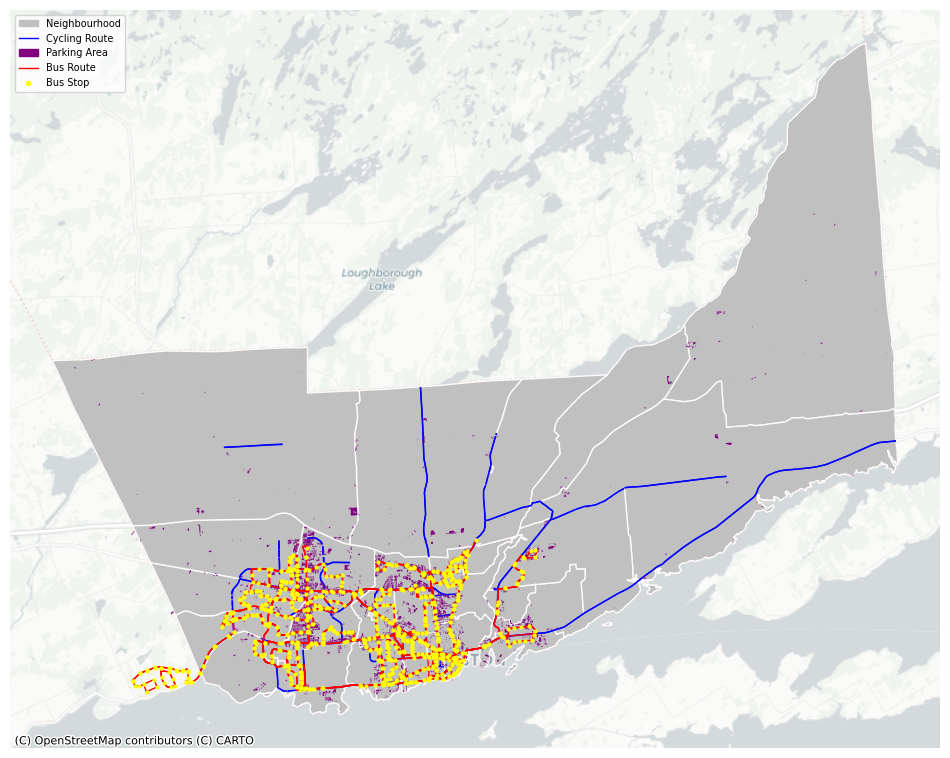

In [504]:
# Plotting the neighbourhoods as the base layer
ax = gdf_neighbourhood.plot(figsize=(12, 12), color='silver', edgecolor='snow', zorder=3)

# Overlay other layers
gdf_cycling.plot(ax=ax, color='blue', linewidth=1, zorder=4)
gdf_parking.plot(ax=ax, color='purple', markersize=10, zorder=5)
gdf_route.plot(ax=ax, color='red', linewidth=1, zorder=6)
gdf_stop.plot(ax=ax, color='yellow', markersize=4, zorder=7)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Create legend handles
neighbourhood_patch = mpatches.Patch(color='silver', edgecolor='snow', label='Neighbourhood')
cycling_line = mlines.Line2D([], [], color='blue', linewidth=1, label='Cycling Route')
parking_patch = mpatches.Patch(color='purple', label='Parking Area')
route_line = mlines.Line2D([], [], color='red', linewidth=1, label='Bus Route')
stop_patch = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None', markersize=3, label='Bus Stop')

# Add the legend to the plot
ax.legend(handles=[neighbourhood_patch, cycling_line, parking_patch, route_line, stop_patch], loc='upper left',fontsize=7)

# Set the axis off
ax.set_axis_off()

# Show the plot
plt.show()

zoom in the plot

In [41]:
# Find the minx,miny,maxx,maxy to formulate a boundry box
bounds_route = gdf_route.total_bounds
bounds_stop = gdf_stop.total_bounds
print("bounds_route: "+ str(bounds_route)+", bounds_stop: " + str(bounds_stop))

bounds_route: [-8534581.49441876  5499150.30943579 -8509069.29351876  5508715.41729721], bounds_stop: [-8534573.70205441  5499162.73525214 -8509157.23591649  5508715.41729721]


<ipython-input-48-bcfb40cf05e5>:40: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  neighbourhood_patch = mpatches.Patch(color='silver', edgecolor='snow', label='Neighbourhood')


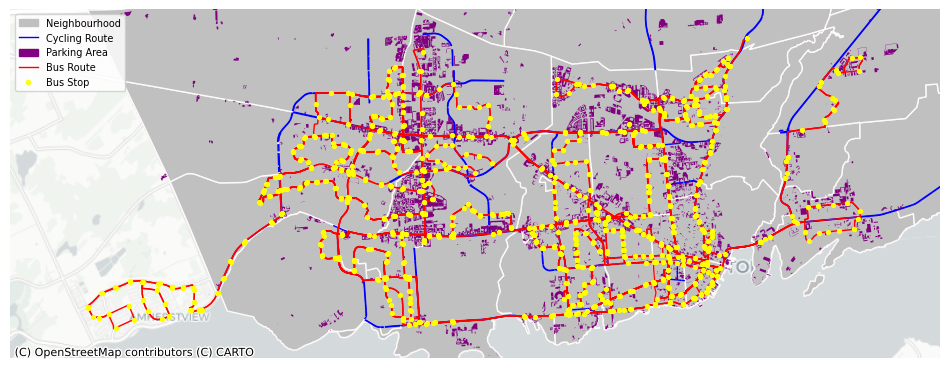

In [48]:
# Find the minx,miny,maxx,maxy to formulate a boundry box
bounds_route = gdf_route.total_bounds
bounds_stop = gdf_stop.total_bounds

# Combine the bounds to cover both routes and stops
minx = min(bounds_route[0], bounds_stop[0])
miny = min(bounds_route[1], bounds_stop[1])
maxx = max(bounds_route[2], bounds_stop[2])
maxy = max(bounds_route[3], bounds_stop[3])

# Add some padding to the bounds to ensure the view is more comfortable
# Extend the boundry box by 10%
padding_x = (maxx - minx) * 0.1  # 10% padding on the x-axis
padding_y = (maxy - miny) * 0.1  # 10% padding on the y-axis

minx -= padding_x
miny -= padding_y
maxx += padding_x
maxy += padding_y

# Create a new figure and axis object for the zoomed-in plot
fig, ax_zoom = plt.subplots(figsize=(12, 12))

# Re-plot all layers on the new axis object
gdf_neighbourhood.plot(ax=ax_zoom, color='silver', edgecolor='snow', zorder=3)
gdf_cycling.plot(ax=ax_zoom, color='blue', linewidth=1, zorder=4)
gdf_parking.plot(ax=ax_zoom, color='purple', markersize=10, zorder=5)
gdf_route.plot(ax=ax_zoom, color='red', linewidth=1, zorder=6)
gdf_stop.plot(ax=ax_zoom, color='yellow', markersize=8, zorder=7)


# Set the x and y limits to the bounding box coordinates
ax_zoom.set_xlim(minx, maxx)
ax_zoom.set_ylim(miny, maxy)

# Add a basemap for the zoomed-in plot
ctx.add_basemap(ax_zoom, source=ctx.providers.CartoDB.Positron)

# Create legend handles
neighbourhood_patch = mpatches.Patch(color='silver', edgecolor='snow', label='Neighbourhood')
cycling_line = mlines.Line2D([], [], color='blue', linewidth=1, label='Cycling Route')
parking_patch = mpatches.Patch(color='purple', label='Parking Area')
route_line = mlines.Line2D([], [], color='red', linewidth=1, label='Bus Route')
stop_patch = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None', markersize=3, label='Bus Stop')

# Add the legend to the plot
ax_zoom.legend(handles=[neighbourhood_patch, cycling_line, parking_patch, route_line, stop_patch], loc='upper left',fontsize=7)

# Remove the axis for a cleaner map
ax_zoom.set_axis_off()

# Show the plot
plt.show()

# Assess Accessibility of Parking Area

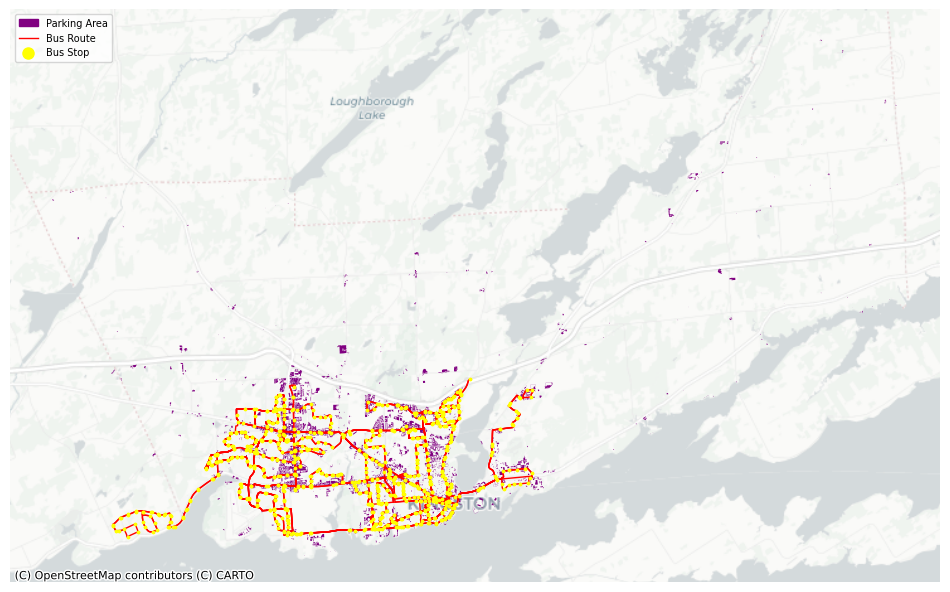

In [123]:
# Create a new figure and axis object for another plot
fig, ax_zoom = plt.subplots(figsize=(12, 12))

# Re-plot all layers on the new axis object
gdf_parking.plot(ax=ax_zoom, color='purple', markersize=10, zorder=5)
gdf_route.plot(ax=ax_zoom, color='red', linewidth=1, zorder=6)
gdf_stop.plot(ax=ax_zoom, color='yellow', markersize=3, zorder=7)

'''
# Set the x and y limits to the bounding box coordinates
ax_zoom.set_xlim(minx, maxx)
ax_zoom.set_ylim(miny, maxy)
'''

# Add a basemap
ctx.add_basemap(ax_zoom, source=ctx.providers.CartoDB.Positron)

# Create legend handles
parking_patch = mpatches.Patch(color='purple', label='Parking Area')
route_line = mlines.Line2D([], [], color='red', linewidth=1, label='Bus Route')
stop_patch = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None', markersize=8, label='Bus Stop')

# Add the legend to the plot
ax_zoom.legend(handles=[parking_patch, route_line, stop_patch], loc='upper left',fontsize=7)

# Remove the axis for a cleaner map
ax_zoom.set_axis_off()

# Show the plot
plt.show()

In [124]:
parking_id_num = len(gdf_parking["parking_area_id"].unique())
parking_num = len(gdf_parking["geometry"].unique())
parking_dataset_num = gdf_parking.shape[0]

print("Parking_id #: "+ str(parking_id_num)+"\n"+
    "Geometry #: "+ str(parking_num)+"\n"+
    "Actual Entry #:" +str(parking_dataset_num))
# we know that Parking_id cannot be used as unique identifier

Parking_id #: 2127
Geometry #: 2725
Actual Entry #:2725


In [126]:
# Step 1: Calculate centroids for parking areas
gdf_parking_analytics = gdf_parking.copy()

gdf_parking_analytics['centroid'] = gdf_parking_analytics.geometry.centroid

# Step 2: Create a 400m buffer around each parking centroid
# and convert the buffer to a GeoDataFrame
gdf_parking_analytics['buffer'] = gdf_parking_analytics.centroid.buffer(400)  # 400 meters is the walking distance threshold
gdf_parking_buffer = gpd.GeoDataFrame(geometry=gdf_parking_analytics['buffer'], crs=gdf_parking_analytics.crs)

# Ensure the index of gdf_parking_buffer is aligned with gdf_parking for accurate score assignment later
gdf_parking_buffer.index = gdf_parking_analytics.index

# Step 3: Perform a spatial join to find bus stops within each parking area's buffer
parking_stop_join = gpd.sjoin(gdf_parking_buffer, gdf_stop, predicate='intersects', how='left')

In [127]:
# calculate the number of parking lots that do not have any bus stops within 400m walking distance
parking_stop_join["index_right"].isnull().sum()

681

In [128]:
# Step 4: Count the number of bus stops within each parking area's buffer
# Filter out the rows where 'index_right' is NaN before grouping
valid_intersections = parking_stop_join[parking_stop_join['index_right'].notna()]

# Now group by the index of the parking areas and count the number of valid intersections
accessibility_counts = valid_intersections.groupby(valid_intersections.index).size()
# Map the counts back to the original parking areas, filling in zeros where there are no intersections
gdf_parking_analytics['accessibility_score'] = accessibility_counts.reindex(gdf_parking_analytics.index, fill_value=0)

# Calculate overall accessibility metrics
average_score = gdf_parking_analytics['accessibility_score'].mean()
percentage_accessible = (gdf_parking_analytics['accessibility_score'] > 0).mean() * 100

print(f"Average Accessibility Score: {average_score:.2f}")
print(f"Percentage of Parking Areas within 400m of a Bus Stop: {percentage_accessible:.2f}%")

Average Accessibility Score: 3.48
Percentage of Parking Areas within 400m of a Bus Stop: 75.01%


In [129]:
# Extract Parking area with & without any bus stops within 400m walking distance
buffer_without_stop = gdf_parking_analytics[gdf_parking_analytics["accessibility_score"] == 0]["buffer"]
buffer_with_stop = gdf_parking_analytics[gdf_parking_analytics["accessibility_score"] != 0]["buffer"]

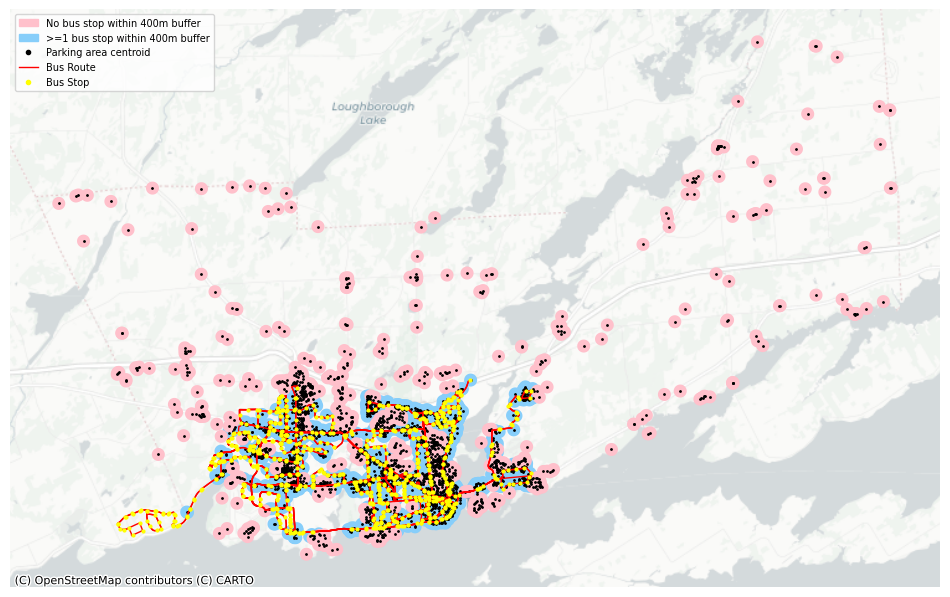

In [130]:
# Create a new figure and axis object for the zoomed-in plot
gdf_parking_analytics
fig, ax_zoom = plt.subplots(figsize=(12, 12))

# Re-plot all layers on the new axis object
buffer_with_stop.plot(ax=ax_zoom, color='lightskyblue', markersize=1, zorder=2)
buffer_without_stop.plot(ax=ax_zoom, color='pink', markersize=1, zorder=2)

# gdf_parking_analytics.plot(ax=ax_zoom, color='purple', markersize=10, zorder=4)
gdf_parking_analytics['centroid'].plot(ax=ax_zoom, color='black', markersize=1, zorder=5)
gdf_route.plot(ax=ax_zoom, color='red', linewidth=1, zorder=6)
gdf_stop.plot(ax=ax_zoom, color='yellow', markersize=4, zorder=7)

# Add a basemap for the zoomed-in plot
ctx.add_basemap(ax_zoom, source=ctx.providers.CartoDB.Positron)

# Create legend handles
without_stop_within_400 = mpatches.Patch(color='pink', label='No bus stop within 400m buffer')
with_stop_within_400 = mpatches.Patch(color='lightskyblue', label='>=1 bus stop within 400m buffer')
centroid_patch = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=3, label='Parking area centroid')
route_line = mlines.Line2D([], [], color='red', linewidth=1, label='Bus Route')
stop_patch = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None', markersize=3, label='Bus Stop')

# Add the legend to the plot
ax_zoom.legend(handles=[without_stop_within_400,with_stop_within_400,centroid_patch, route_line, stop_patch], loc='upper left',fontsize=7)

# Remove the axis for a cleaner map
ax_zoom.set_axis_off()

# Show the pl
plt.show()

# Solve Accessibility of Cycling Routes

In [498]:
# Create copies of the original GeoDataFrames for analysis
gdf_cycling_analytics = gdf_cycling.copy()
gdf_bus_routes_analytics = gdf_route.copy()

In [499]:
gdf_cycling_analytics['buffer_1000m'] = gdf_cycling_analytics.geometry.buffer(1000)

# Convert the buffered geometry to a GeoDataFrame for spatial join
gdf_cycling_buffer = gpd.GeoDataFrame(gdf_cycling_analytics, geometry='buffer_1000m', crs=gdf_cycling.crs)
# Perform a spatial join with bus stops
stops_within_cycling_buffer = gpd.sjoin(gdf_cycling_buffer, gdf_stop, predicate='intersects', how='left')
# Group by cycling route and check for any bus stops within the buffer
cycling_accessibility = stops_within_cycling_buffer.groupby(stops_within_cycling_buffer.index).apply(lambda x: x['index_right'].notnull().any())
# Calculate the percentage of cycling routes with at least one bus stop within 1000m
percentage_accessible = (cycling_accessibility.mean() * 100)
print(f"Percentage of Cycling Routes with at least one Bus Stop within 1000m: {percentage_accessible:.2f}%")

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Percentage of Cycling Routes with at least one Bus Stop within 1000m: 85.68%


In [501]:
# Calculate the route with/without at least 1 bus stop within the 1000m buffer
route_with_stop = gdf_cycling_analytics[cycling_accessibility]
route_without_stop = gdf_cycling_analytics[~cycling_accessibility]

<ipython-input-503-c6b07e794828>:15: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  buffer_patch = mpatches.Patch(color='lightblue', edgecolor='snow', label='1000m-buffer')


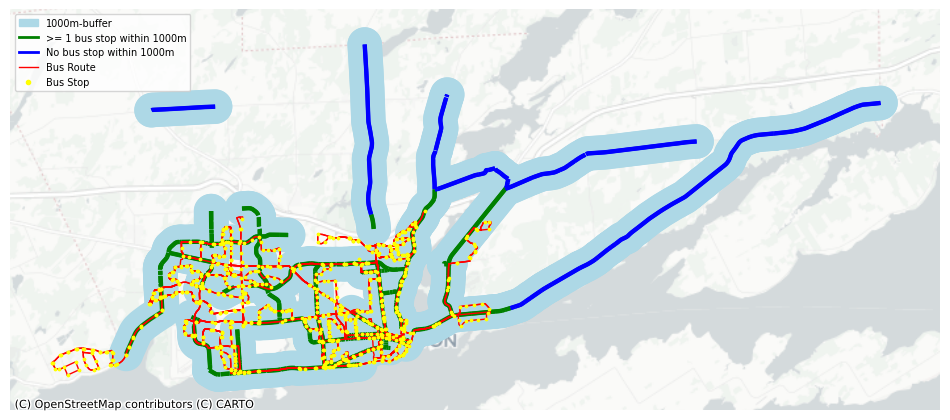

In [503]:
# Create a new figure and axis object for the zoomed-in plot
fig, ax_zoom = plt.subplots(figsize=(12, 12))

# Re-plot all layers on the new axis object
route_with_stop["geometry"].plot(ax=ax_zoom, color='green', linewidth=3, zorder=3)
route_without_stop["geometry"].plot(ax=ax_zoom, color='blue', linewidth=3, zorder=3)
gdf_cycling_analytics['buffer_1000m'].plot(ax=ax_zoom, color='lightblue', markersize=1, zorder=2)
gdf_route.plot(ax=ax_zoom, color='red', linewidth=1, zorder=4)
gdf_stop.plot(ax=ax_zoom, color='yellow', markersize=3, zorder=5)

# Add a basemap for the zoomed-in plot
ctx.add_basemap(ax_zoom, source=ctx.providers.CartoDB.Positron)

# Create legend handles
buffer_patch = mpatches.Patch(color='lightblue', edgecolor='snow', label='1000m-buffer')
cycling_route_with_stop = mlines.Line2D([], [], color='green', linewidth=2, label='>= 1 bus stop within 1000m')
cycling_route_without_stop = mlines.Line2D([], [], color='blue', linewidth=2, label='No bus stop within 1000m')
bus_route_line = mlines.Line2D([], [], color='red', linewidth=1, label='Bus Route')
stop_patch = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None', markersize=3, label='Bus Stop')

# Add the legend to the plot
ax_zoom.legend(handles=[buffer_patch, cycling_route_with_stop, cycling_route_without_stop, bus_route_line, stop_patch], loc='upper left',fontsize=7)

# Remove the axis for a cleaner map
ax_zoom.set_axis_off()

# Show the plot
plt.show()

# Solve Accessibility of Neighbourhoods

In [56]:
# Create copies of the original GeoDataFrames for analysis
gdf_address_analytics = gdf_address.copy()
gdf_neighbourhood_analytics = gdf_neighbourhood.copy()
gdf_stop_analytics = gdf_stop.copy()

In [57]:
# Buffer bus stops by 400 meters
gdf_stop_analytics['buffer'] = gdf_stop_analytics.geometry.buffer(400)


In [58]:
# Convert the buffered geometry to a GeoDataFrame for spatial join
gdf_stop_buffer = gpd.GeoDataFrame(gdf_stop_analytics, geometry='buffer', crs=gdf_stop_analytics.crs)

In [66]:
# Perform a spatial join between addresses and buffered bus stops
addresses_within_stop_buffer = gpd.sjoin(gdf_address_analytics, gdf_stop_buffer, how='inner', predicate='intersects')

In [121]:
gdf_address_analytics['geometry'].value_counts()

POINT (-8515901.349 5502088.180)    341
POINT (-8516221.315 5502194.207)    340
POINT (-8515099.938 5501637.658)    252
POINT (-8521032.142 5505591.041)    233
POINT (-8515438.783 5501756.404)    211
                                   ... 
POINT (-8519245.353 5503536.351)      1
POINT (-8516014.472 5500626.848)      1
POINT (-8515477.823 5501317.068)      1
POINT (-8517881.801 5499869.186)      1
POINT (-8526015.237 5501236.095)      1
Name: geometry, Length: 47942, dtype: int64

In [73]:
addresses_within_stop_buffer["geometry_left"].unique()

<GeometryArray>
[<POINT (-8525063.934 5506577.093)>,  <POINT (-8525080.365 5506708.79)>,
 <POINT (-8524892.669 5506736.616)>, <POINT (-8525186.308 5506507.297)>,
 <POINT (-8524848.642 5506750.327)>, <POINT (-8525243.793 5506398.282)>,
 <POINT (-8525064.958 5506703.023)>, <POINT (-8525246.053 5506720.247)>,
 <POINT (-8525246.453 5506731.222)>, <POINT (-8525246.598 5506593.042)>,
 ...
 <POINT (-8522937.943 5503421.809)>, <POINT (-8522986.401 5503588.176)>,
 <POINT (-8522995.295 5503581.976)>,  <POINT (-8521471.843 5502368.15)>,
 <POINT (-8521582.384 5502387.557)>, <POINT (-8522539.575 5499417.282)>,
 <POINT (-8522519.516 5499265.358)>, <POINT (-8522712.321 5499195.167)>,
 <POINT (-8522242.564 5499214.287)>, <POINT (-8519772.251 5499278.778)>]
Length: 35805, dtype: geometry

In [97]:
unique_addresses_within_buffer_count = addresses_within_stop_buffer['geometry_left'].drop_duplicates().shape[0]

# Count total unique addresses based on geometry in the original addresses GeoDataFrame
total_addresses_count = gdf_address_analytics.geometry.drop_duplicates().shape[0]

# Calculate the proportion of unique addresses within 400m of a bus stop
proportion_within_buffer = unique_addresses_within_buffer_count / total_addresses_count * 100

print(f"Proportion of unique addresses within 400m of a bus stop: {proportion_within_buffer:.2f}%")

Proportion of unique addresses within 400m of a bus stop: 74.68%


<ipython-input-102-dc08bc7884a4>:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  neighbourhood_patch = mpatches.Patch(color='silver', edgecolor='snow', label='Neighbourhood')


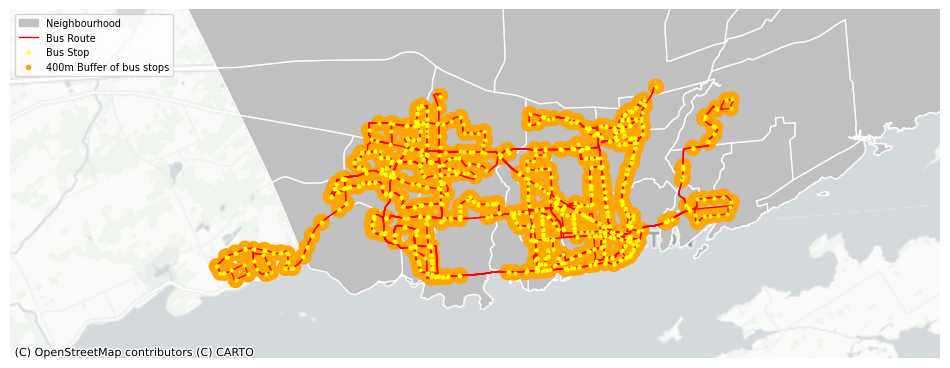

In [102]:
# Create a new figure and axis object for the zoomed-in plot
fig, ax_zoom = plt.subplots(figsize=(12, 12))

gdf_stop_analytics['buffer'].plot(ax=ax_zoom, color='orange', markersize=1, zorder=3)
gdf_neighbourhood.plot(ax=ax_zoom, color='silver', edgecolor='snow', zorder=2)
gdf_route.plot(ax=ax_zoom, color='red', linewidth=1, zorder=4)
gdf_stop.plot(ax=ax_zoom, color='yellow', markersize=4, zorder=5)

# Add a basemap for the zoomed-in plot
ctx.add_basemap(ax_zoom, source=ctx.providers.CartoDB.Positron)

# Create legend handles
neighbourhood_patch = mpatches.Patch(color='silver', edgecolor='snow', label='Neighbourhood')
buffer_patch = mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=3, label='400m Buffer of bus stops')
route_line = mlines.Line2D([], [], color='red', linewidth=1, label='Bus Route')
stop_patch = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None', markersize=2, label='Bus Stop')

# Add the legend to the plot
ax_zoom.legend(handles=[neighbourhood_patch,route_line, stop_patch, buffer_patch], loc='upper left',fontsize=7)

# set the boundry box
# Find the minx,miny,maxx,maxy to formulate a boundry box
bounds_route = gdf_route.total_bounds
bounds_stop = gdf_stop.total_bounds

# Combine the bounds to cover both routes and stops
minx = min(bounds_route[0], bounds_stop[0])
miny = min(bounds_route[1], bounds_stop[1])
maxx = max(bounds_route[2], bounds_stop[2])
maxy = max(bounds_route[3], bounds_stop[3])

# Add some padding to the bounds to ensure the view is more comfortable
# Extend the boundry box by 40%
padding_x = (maxx - minx) * 0.4  # 40% padding on the x-axis
padding_y = (maxy - miny) * 0.4  # 40% padding on the y-axis

minx -= padding_x
miny -= padding_y
maxx += padding_x
maxy += padding_y

ax_zoom.set_xlim(minx, maxx)
ax_zoom.set_ylim(miny, maxy)

# Remove the axis for a cleaner map
ax_zoom.set_axis_off()

# Show the pl
plt.show()

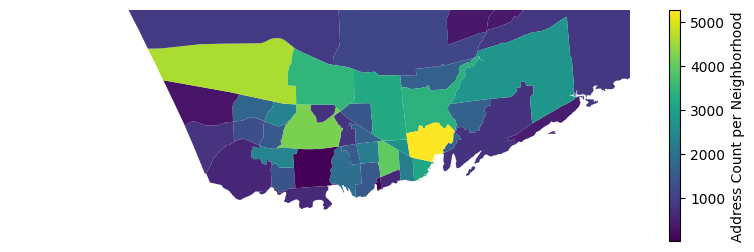

In [116]:
# Aggregate addresses by neighborhood
address_counts_per_neighborhood = gdf_address_analytics['neighbourhood'].value_counts()

# Merge this count back into gdf_neighbourhood for visualization
# Assuming gdf_neighbourhood is already defined and has a 'name' or similar column matching 'neighbourhood' in gdf_address_analytics
gdf_neighbourhood['address_count'] = gdf_neighbourhood['name'].map(address_counts_per_neighborhood)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
gdf_neighbourhood.plot(column='address_count', ax=ax, legend=True, cmap='viridis',
                       legend_kwds={'label': 'Address Count per Neighborhood','shrink':0.3})

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_axis_off()
plt.show()

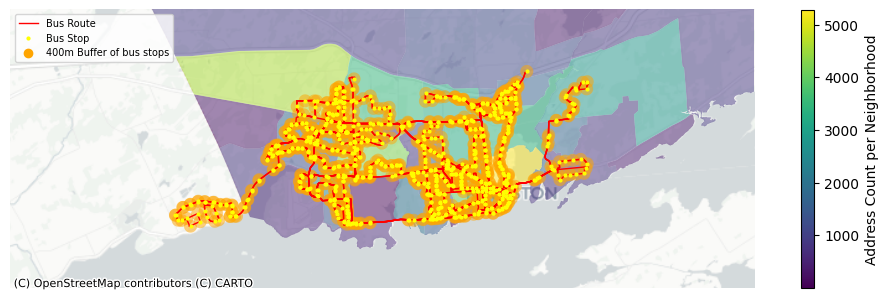

In [118]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot neighborhood heatmap
gdf_neighbourhood.plot(column='address_count', ax=ax, cmap='viridis', legend=True,
                       legend_kwds={'label': 'Address Count per Neighborhood','shrink':0.3}, alpha=0.5)

# Overlay other spatial layers
gdf_stop_analytics['buffer'].plot(ax=ax, color='orange', alpha=0.5, zorder=3)
gdf_route.plot(ax=ax, color='red', linewidth=1, zorder=4)
gdf_stop.plot(ax=ax, color='yellow', markersize=4, zorder=5)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Setting the boundary box with padding as calculated
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Remove axis for cleaner map
ax.set_axis_off()

# Add legend for the overlay layers
#neighbourhood_patch = mpatches.Patch(color='silver', edgecolor='snow', label='Neighbourhood')
buffer_patch = mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=6, label='400m Buffer of bus stops')
route_line = mlines.Line2D([], [], color='red', linewidth=1, label='Bus Route')
stop_patch = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None', markersize=2, label='Bus Stop')

ax.legend(handles=[route_line, stop_patch, buffer_patch], loc='upper left',fontsize=7)

plt.show()